In [1]:
import torch
import sys
import os
import numpy as np
from umap.umap_ import find_ab_params

from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.losses import SingleVisLoss, UmapLoss, ReconstructionLoss
from singleVis.trainer import SingleVisTrainer
from singleVis.data import DataProvider
from singleVis.visualizer import visualizer
import singleVis.config as config

In [2]:
DATASET = "cifar10"
# CONTENT_PATH = "/home/xianglin/projects/DVI_data/TemporalExp/resnet18_{}".format(DATASET)
CONTENT_PATH = "/home/xianglin/projects/DVI_data/resnet18_{}".format(DATASET)
DATASET = "cifar10_full"

In [3]:
content_path = CONTENT_PATH
sys.path.append(content_path)

In [4]:
from Model.model import *
net = resnet18()
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [5]:
GPU_ID = 0
LEN = config.dataset_config[DATASET]["TRAINING_LEN"]
LAMBDA = config.dataset_config[DATASET]["LAMBDA"]
L_BOUND = config.dataset_config[DATASET]["L_BOUND"]
MAX_HAUSDORFF = config.dataset_config[DATASET]["MAX_HAUSDORFF"]
ALPHA = config.dataset_config[DATASET]["ALPHA"]
BETA = config.dataset_config[DATASET]["BETA"]
INIT_NUM = config.dataset_config[DATASET]["INIT_NUM"]
EPOCH_START = config.dataset_config[DATASET]["EPOCH_START"]
EPOCH_END = config.dataset_config[DATASET]["EPOCH_END"]
EPOCH_PERIOD = config.dataset_config[DATASET]["EPOCH_PERIOD"]

# define hyperparameters
DEVICE = torch.device("cuda:{:d}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
S_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["S_N_EPOCHS"]
B_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["B_N_EPOCHS"]
T_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["T_N_EPOCHS"]
N_NEIGHBORS = config.dataset_config[DATASET]["training_config"]["N_NEIGHBORS"]
PATIENT = config.dataset_config[DATASET]["training_config"]["PATIENT"]
MAX_EPOCH = config.dataset_config[DATASET]["training_config"]["MAX_EPOCH"]


data_provider = DataProvider(content_path, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, verbose=1)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256)
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA)

optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)

trainer = SingleVisTrainer(model, criterion, optimizer, lr_scheduler, edge_loader=None, DEVICE=DEVICE)
trainer.load(file_path=os.path.join(data_provider.model_path,"tnn.pth"))

Finish initialization...
Successfully load visualization model...


# temporal nn spearman ranking test

In [21]:
EPOCH = 200

In [22]:
all_train_repr = np.zeros((EPOCH,LEN,512))
for i in range(1,201, 1):
    all_train_repr[i-1] = data_provider.train_representation(i)

model = trainer.model

In [23]:
low_repr = np.zeros((EPOCH,LEN,2))
for e in range(EPOCH):
    low_repr[e] = model.encoder(torch.from_numpy(all_train_repr[e]).to(device=DEVICE).float()).detach().cpu().numpy()

In [24]:
from scipy import stats

In [25]:
# shape (200, 50000, 512)
epochs = [i for i in range(EPOCH)]
corrs = np.zeros((EPOCH,500))
ps = np.zeros((EPOCH,500))
for i in range(500):
    high_embeddings = all_train_repr[:,i,:].squeeze()
    low_embeddings = low_repr[:,i,:].squeeze()

    for e in epochs:
        high_dists = np.linalg.norm(high_embeddings - high_embeddings[e], axis=1)
        low_dists = np.linalg.norm(low_embeddings - low_embeddings[e], axis=1)
        corr, p = stats.spearmanr(high_dists, low_dists)
        corrs[e][i] = corr
        ps[e][i] = p


<function matplotlib.pyplot.show(close=None, block=None)>

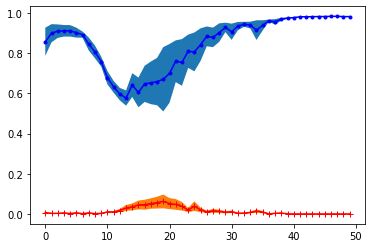

In [ ]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

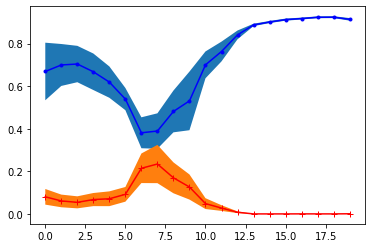

In [ ]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

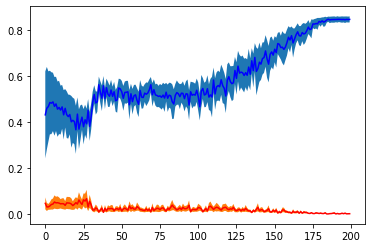

In [26]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b-", epochs, mean_p, "r-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

# fixing invarient and Moving invarient

In [27]:
from scipy.special import softmax
from scipy import stats
from scipy.spatial.distance import cosine

In [28]:
e_s = 2
e_t = 40

In [29]:
train_data_s = data_provider.train_representation(e_s)
train_data_t = data_provider.train_representation(e_t)
pred_s = data_provider.get_pred(e_s, train_data_s)
pred_t = data_provider.get_pred(e_t, train_data_t)

labels = data_provider.train_labels(20)

model = trainer.model

low_s = model.encoder(torch.from_numpy(train_data_s).to(device=DEVICE).float()).detach().cpu().numpy()
low_t = model.encoder(torch.from_numpy(train_data_t).to(device=DEVICE).float()).detach().cpu().numpy()


100%|██████████| 250/250 [00:00<00:00, 12105.19it/s]


## correlation between (kl div/js div/loss) and dists

In [9]:
def kl_div(p, q):
    return stats.entropy(p, q, base=2)


def js_div(p, q):
    M = (p+q)/2
    return .5*kl_div(p, M)+.5*kl_div(q, M)

In [15]:
# kl
softmax_s = softmax(pred_s, axis=1)
softmax_t = softmax(pred_t, axis=1)
kl_lists = [kl_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))]
dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(kl_lists, dists)
corr, p

(0.5488607797007168, 0.0)

In [11]:
# js
js_lists = [js_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))]
dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(js_lists, dists)
corr, p

(0.4541439913698421, 0.0)

In [12]:
# loss
loss_s = softmax_s[range(LEN), labels]
loss_t = softmax_t[range(LEN), labels]
loss_diff = np.abs(loss_s-loss_t)

dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(js_lists, dists)
corr, p

(0.4541439913698421, 0.0)

## fixing and moving comparison

In [30]:
# normalize low dimension distance
mean_x = np.mean(low_t[:, 0])
mean_y = np.mean(low_t[:, 1])
low_t = low_t - [mean_x, mean_y]
low_s = low_s - [mean_x, mean_y]

max_n = np.linalg.norm(low_t)
low_t = low_t/max_n*100
low_s = low_s/max_n*100


In [31]:
np.linalg.norm((train_data_s-train_data_t),axis=1).mean(), np.linalg.norm((low_s-low_t),axis=1).mean()

(16.255549191454307, 0.050163385)

In [32]:
selected = np.argsort(kl_lists)
print("kl div")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

kl div
fixing	 15.75666724388946 0.041344266
moving	 19.623843760000035 0.3032372


In [47]:
selected = np.argsort(js_lists)
print("js div")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

js div
fixing	 0.2784126328281036 0.03147343
moving	 7.4485370476654165 0.4833563


In [48]:
selected = np.argsort(loss_diff)
print("loss diff")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

loss diff
fixing	 0.46239914135667326 0.056479488
moving	 7.489972076625427 0.5053706


## inside(outside)-class moving dists

In [28]:
p_s = pred_s.argmax(axis=1)
p_t = pred_t.argmax(axis=1)
for i in range(10):
    selected = np.logical_and(p_s==i, p_s==p_t)
    print(i, np.linalg.norm((train_data_s-train_data_t)[selected],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected],axis=1).mean())

0 2.242571759038472 0.2807122
1 1.9868760818159548 0.28744134
2 2.234642765342308 0.06597897
3 2.8872040254482236 0.27273202
4 2.044586344685677 0.32637545
5 2.11392919954649 0.12015249
6 2.0157244661746603 0.16108343
7 2.2055391471862493 0.1335515
8 1.936219060649511 0.25233826
9 1.9095602665506444 0.24290018


In [29]:
for i in range(10):
    selected = np.logical_and(p_s==i, p_s!=p_t)
    print(i, np.linalg.norm((train_data_s-train_data_t)[selected],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected],axis=1).mean())

0 5.213860885361575 0.4695684
1 4.616854768709955 0.50073403
2 4.994951531264888 0.32757828
3 4.98905760160238 0.2608999
4 5.323860879365539 0.35342965
5 5.189055546448453 0.30009905
6 5.12417897006201 0.23139767
7 5.079772257519198 0.3576349
8 5.080165057823443 0.28915018
9 4.828743283767612 0.3504236


## npr and prediction based measurements

In [32]:
from singleVis.backend import find_neighbor_preserving_rate

npr = find_neighbor_preserving_rate(train_data_s, train_data_t, 15)
selected_fix = np.logical_and(npr>0.1, p_s==p_t)
for i in range(10):
    selected = np.logical_and(selected_fix, p_s==i)
    print(i, np.linalg.norm((train_data_s-train_data_t)[selected],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected],axis=1).mean())

0 2.176139782249106 0.29397196
1 2.074862558706502 0.30089507
2 2.1669348852993267 0.06359337
3 2.573793916028262 0.27241808
4 1.8849163680567051 0.28098086
5 1.9835538611280263 0.11856113
6 1.9314286626546866 0.1589594
7 2.2124167143457223 0.1432588
8 1.9322340303954333 0.2479699
9 1.9192794587049762 0.25507292


# fixing and moving invariants

## moving

In [59]:
e_s = 40
e_t = 50

In [60]:
train_data_s = data_provider.train_representation(e_s)
train_data_t = data_provider.train_representation(e_t)
pred_s = data_provider.get_pred(e_s, train_data_s)
pred_t = data_provider.get_pred(e_t, train_data_t)

labels = data_provider.train_labels(20)

model = trainer.model

low_s = model.encoder(torch.from_numpy(train_data_s).to(device=DEVICE).float()).detach().cpu().numpy()
low_t = model.encoder(torch.from_numpy(train_data_t).to(device=DEVICE).float()).detach().cpu().numpy()

100%|██████████| 300/300 [00:00<00:00, 11495.34it/s]


In [61]:
from singleVis.utils import is_B
s_B = is_B(pred_s)
t_B = is_B(pred_t)

predictions_s = pred_s.argmax(1)
predictions_t = pred_t.argmax(1)

confident_sample = np.logical_and(np.logical_not(s_B),np.logical_not(t_B))
diff_pred = predictions_s!=predictions_t

selected = np.logical_and(diff_pred, confident_sample)


In [62]:
from singleVis.visualizer import visualizer
resolution = 500
vis = visualizer(data_provider, trainer.model, resolution, 10, classes, cmap='tab10')

In [63]:
grid_view_s, decision_view_s = vis.get_epoch_decision_view(e_s, resolution)
grid_view_t, decision_view_t = vis.get_epoch_decision_view(e_t, resolution)

grid_view_s = grid_view_s.reshape(resolution*resolution, -1)
grid_view_t = grid_view_t.reshape(resolution*resolution, -1)

grid_samples_s = trainer.model.decoder(grid_view_s).cpu().detach().numpy()
grid_samples_t = trainer.model.decoder(grid_view_t).cpu().detach().numpy()

grid_pred_s = data_provider.get_pred(e_s, grid_samples_s)+1e-8
grid_pred_t = data_provider.get_pred(e_t, grid_samples_t)+1e-8


Computing decision regions ...


100%|██████████| 1250/1250 [00:00<00:00, 2752.47it/s]


Computing decision regions ...


100%|██████████| 1250/1250 [00:00<00:00, 3518.18it/s]


In [64]:
grid_view_s = grid_view_s.cpu().detach().numpy()
grid_view_t = grid_view_t.cpu().detach().numpy()

In [65]:
grid_s_B = is_B(grid_pred_s)
grid_t_B = is_B(grid_pred_t)

grid_predictions_s = grid_pred_s.argmax(1)
grid_predictions_t = grid_pred_t.argmax(1)


In [66]:
from sklearn.neighbors import NearestNeighbors

In [67]:
high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
high_neigh.fit(grid_view_s)
knn_dists, knn_indices = high_neigh.kneighbors(low_s, n_neighbors=1, return_distance=True)

close_s_pred = grid_predictions_s[knn_indices].squeeze()
close_s_B = grid_s_B[knn_indices].squeeze()

In [68]:
s_true = np.logical_and(close_s_pred==predictions_s, close_s_B == s_B)
np.sum(s_true[selected]), np.sum(selected)

(119, 149)

In [69]:
high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
high_neigh.fit(grid_view_t)
knn_dists, knn_indices = high_neigh.kneighbors(low_t, n_neighbors=1, return_distance=True)

close_t_pred = grid_predictions_t[knn_indices].squeeze()
close_t_B = grid_t_B[knn_indices].squeeze()
np.sum(grid_t_B), np.sum(t_B)

(34162, 1)

In [70]:
t_true = np.logical_and(close_t_pred==predictions_t, close_t_B == t_B)
np.sum(t_true[selected]), np.sum(selected)

(148, 149)

In [71]:
np.sum(np.logical_and(s_true[selected], t_true[selected])), np.sum(selected)

(118, 149)

## fixing

In [6]:
# moving invariants
from scipy.special import softmax
from scipy import stats
from scipy.spatial.distance import cosine

In [7]:
def kl_div(p, q):
    return stats.entropy(p, q, base=2)


def js_div(p, q):
    M = (p+q)/2
    return .5*kl_div(p, M)+.5*kl_div(q, M)

In [39]:
e_s = 140
e_t = 150

In [40]:
train_data_s = data_provider.train_representation(e_s)
train_data_t = data_provider.train_representation(e_t)
pred_s = data_provider.get_pred(e_s, train_data_s)
pred_t = data_provider.get_pred(e_t, train_data_t)
softmax_s = softmax(pred_s, axis=1)
softmax_t = softmax(pred_t, axis=1)

labels = data_provider.train_labels(20)

model = trainer.model

low_s = model.encoder(torch.from_numpy(train_data_s).to(device=DEVICE).float()).detach().cpu().numpy()
low_t = model.encoder(torch.from_numpy(train_data_t).to(device=DEVICE).float()).detach().cpu().numpy()

100%|██████████| 250/250 [00:00<00:00, 12076.89it/s]


In [41]:
# normalize low_t
y_max = max(low_s[:, 1].max(), low_t[:, 1].max())
y_min = max(low_s[:, 1].min(), low_t[:, 1].min())
x_max = max(low_s[:, 0].max(), low_t[:, 0].max())
x_min = max(low_s[:, 0].min(), low_t[:, 0].min())
scale =min(100/(x_max - x_min), 100/(y_max - y_min))
low_t = low_t*scale
low_s = low_s*scale

In [42]:
high_dists = np.linalg.norm(train_data_s-train_data_t, axis=1)
softmax_dists = np.array([js_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))])
euclidean_dists = np.linalg.norm(low_s-low_t, axis=1)
# cosine_dists = np.array([cosine(low_t[i], low_s[i]) for i in range(len(low_s))])

In [43]:
# find the minimum distance
from pynndescent import NNDescent
# number of trees in random projection forest
n_trees = min(64, 5 + int(round((train_data_s.shape[0]) ** 0.5 / 20.0)))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(train_data_s.shape[0]))))
# distance metric
metric = "euclidean"
# metric = "cosine"
# get nearest neighbors

nnd = NNDescent(
    train_data_s,
    n_neighbors=2,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=False
)
knn_indices, knn_dists = nnd.neighbor_graph

In [44]:
nn_ind = knn_dists[:, 1]
nn_dists = knn_dists[:, 1]

In [49]:
threshold = nn_dists.max()
selected = high_dists<=threshold
if np.sum(selected) == 0:
    print("No fixing points!")
else:
# selected = np.argsort(high_dists)[:100]
    print("euclidean dists")
    print(euclidean_dists[selected].min(), euclidean_dists.min())
    print(euclidean_dists[selected].mean(), euclidean_dists.mean())
    print(euclidean_dists[selected].max(), euclidean_dists.max())

euclidean dists
0.017941043 0.017941043
5.9246836 11.794313
90.055046 109.36081


In [50]:
softmax_diff = np.array([js_div(softmax_s[i], softmax_s[j]) for (i,j) in knn_indices])
threshold = softmax_diff.max()
selected = softmax_dists<=threshold
if np.sum(selected) == 0:
    print("No fixing points!")
else:
# selected = np.argsort(high_dists)[:100]
    print("euclidean dists")
    print(euclidean_dists[selected].min(), euclidean_dists.min())
    print(euclidean_dists[selected].mean(), euclidean_dists.mean())
    print(euclidean_dists[selected].max(), euclidean_dists.max())

euclidean dists
0.017941043 0.017941043
7.9813647 11.794313
109.36081 109.36081


# Graph mutual information
**node and features**
- topology
- mutual information
>>
intrinsic dimension
softmax kl div